### Udacity Data Science Nanodegree
### Capstone Project: Movie recommender
---
# Notebook 1: ETL pipeline preparation

This notebook retrieve, clean and blend movie and review data from IMDb,
TMDB and MovieLens

- [Introduction](#intro)
- [Step 1: Data Gathering](#datagathering)
    * [1.1 Directly download the IMDB and TMDB dataset from Kaggle](#IMDB)
    * [1.2 Download MovieLens data from Grouplens](#movielens)
- [Step 2: Assessing and Cleaning data](#assess)
    * [Step 2.1: IMDB Movie Metadata](#assess_imdb)
    * [Step 2.2: MovieLens Links](#movielens_links)
    * [Step 2.3: MovieLens Ratings](#movielens_ratings)
    * [Step 2.4: MovieLens Tags](#movielens_tags)
    * [Step 2.5: Extra IMDB columns](#imdb_extra)
    * [Summary of assessment and cleaning](#summary)
- [Step 4: Storing Data](#storing)
- [References](#references)
- [Submission](#submission)

<a class='anchor' id='intro'></a>
<h3 style="color:white; font-size:25px; text-align: left; line-height: 1; font-family: Calibri; background-color:#7C9E9E; border-radius:10px; padding: 14px">Introduction</h3>

This notebook, automatically download movie and ratings datasets from Kaggle and Grouplens.
Data are explored,
cleaned and written to parquet files in `data/clean` folder on completion.

In [1]:
from collections import Counter
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

import kaggle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# custom coding
from src import *
from src import Seafoam

# magic word for producing visualizations in notebook
%matplotlib inline

# font standardization
seafoam = Seafoam()

# environment settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 42)
pd.set_option('display.width', 1000)

# stock scientific notation on graphs
pd.options.display.float_format = '{:.2f}'.format

<a id='datagathering'></a>
<h3 style="color:white; font-size:25px; text-align: left; line-height: 1; font-family: Calibri; background-color:#7C9E9E; border-radius:10px; padding: 14px">Step 1: Data Gathering</h3>


Gather datasets from Kaggle automatically

<a id='IMDB'></a>
<span style="color:#7C9E9E; font-size:20px; font-weight:bold">1.1 Directly download the IMDB and TMDB dataset from Kaggle, stored [here](https://www.kaggle.com/datasets/alanvourch/tmdb-movies-daily-updates) </span>

Download IMDB/TMDB movie content data from Kaggle if it does not yet exist

Data source selected for this project can be found
[here](https://www.kaggle.com/datasets/alanvourch/tmdb-movies-daily-updates)

This dataset contains extensive metadata to support
content-based recommendations.

To use the Kaggle API, you need to install the kaggle package by running:
`pip install kaggle`

Before accessing the API, you need to authenticate using an API token.
Follow the steps below:

1) Go to the 'Account' tab on your Kaggle profile.
2) Click 'Create New Token'.
This will download a file named `kaggle.json`
containing your API credentials.
3) Move the `kaggle.json` file to the appropriate location:
    * Linux/OSX: `~/.kaggle/kaggle.json`
    * Windows: `c:/Users/<username>/.kaggle/kaggle.json`

IMPORTANT:
Ensure `kaggle.json` is in the location `~/.kaggle/kaggle.json` to use the API.

Alternatively, the data can be downloaded manually using the above link
and saved in the folder `data/raw/imdb_tmdb/imdb_tmdb.csv`

To refresh the data, manually delete the folder `data/raw/imdb_tmdb`.


In [2]:
# Download data if it does not yet exist.
# To refresh the data, just manually delete the folder `data/raw/imdb_tmdb`

folder_imdb_tmdb_raw = os.path.join('..', folder_raw, folder_imdb_tmdb)

if os.path.isdir(folder_imdb_tmdb_raw) and len(os.listdir(folder_imdb_tmdb_raw)) == 1:
    print('File already exist')
else:
    # API token file `kaggle.json` should exist in `~/.kaggle`
    kaggle.api.authenticate()
    # Download IMDB movie metadata file from Kaggle
    print('Downloading movies metadata')
    kaggle.api.dataset_download_files(url_kaggle_tmdb, path=folder_imdb_tmdb_raw, unzip=True)

    # rename file name
    for filename in os.listdir(folder_imdb_tmdb_raw):
        file_old = os.path.join(folder_imdb_tmdb_raw, filename)
        file_new = os.path.join(folder_imdb_tmdb_raw, filename_imdb_tmdb_raw)
        if filename.startswith("TMDB"):
            os.rename(file_old, file_new)
            print('File renamed from {} to {}'.format(file_old, file_new))

# check that a file was saved in the directory
assert len(os.listdir(folder_imdb_tmdb_raw)) == 1

File already exist


##### Download a similar dataset as above, but with additional interesting columns

In [3]:
# Download data if it does not yet exist.
# To refresh the data, manually delete the folder `data/raw/imdb_tmdb`

folder_imdb_tmdb_raw = os.path.join('..', folder_raw, folder_imdb_tmdb_extra)

if os.path.isdir(folder_imdb_tmdb_raw) and len(os.listdir(folder_imdb_tmdb_raw)) == 1:
    print('File already exist')
else:
    # API token file `kaggle.json` should exist in `~/.kaggle`
    kaggle.api.authenticate()
    # Download IMDB movie metadata file from Kaggle
    print('Downloading movies metadata')
    kaggle.api.dataset_download_files(url_kaggle_tmdb_extra, path=folder_imdb_tmdb_raw, unzip=True)

    # rename file name
    for filename in os.listdir(folder_imdb_tmdb_raw):
        file_old = os.path.join(folder_imdb_tmdb_raw, filename)
        file_new = os.path.join(folder_imdb_tmdb_raw, filename_imdb_tmdb_raw_extra)
        if filename.startswith("IMDB TMDB"):
            os.rename(file_old, file_new)
            print('File renamed from {} to {}'.format(file_old, file_new))

# check that a file was saved in the directory
assert len(os.listdir(folder_imdb_tmdb_raw)) == 1

File already exist


<a id='movielens'></a>
<span style="color:#7C9E9E; font-size:20px; font-weight:bold">1.2 Download MovieLens data from Grouplens</span>

Dataset `ml-32m.zip` can be downloaded manually from Grouplens [here](http://files.grouplens.org/datasets/movielens/)

MovieLens data `ratings.csv` contains ratings of movies by user id and movie id
to support collaborative filtering recommendations.

The zip file also contains a conversion file `links.csv` which links id's of MovieLens,
IMDB, and TMDB together giving us a lot of freedom to blend data from multiple sources.

In [4]:
# Download zip file and extract files
folder_movielens_raw = os.path.join('..', folder_raw, folder_movielens)
if os.path.isdir(folder_movielens_raw) and len(os.listdir(folder_movielens_raw)) >= 1:
    print('File already exist')
else:
    with urlopen(url_movielens) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall(folder_movielens_raw)

File already exist


In [5]:
# check that the MovieLens files were saved in the directory
assert len(os.listdir(folder_movielens_raw)) >= 1

<a id='assess'></a>
<h3 style="color:white; font-size:25px; text-align: left; line-height: 1; font-family: Calibri; background-color:#7C9E9E; border-radius:10px; padding: 14px">Step 2: Assessing and Cleaning Data</h3>






<a id='assess_imdb'></a>
<span style="color:#7C9E9E; font-size:20px; font-weight:bold">2.1 Assess IMDB Movie Metadata</span>

In [6]:
# read IMDB movie metadata and do visual assessment of a sample
path = os.path.join('..', path_imdb_raw)
df_movies_imdb = pd.read_csv(path, parse_dates = ["release_date"])
df_movies_imdb.loc[df_movies_imdb['title'].str.lower().str.contains('hobbit:') == True]

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes,poster_path
32966,49051,The Hobbit: An Unexpected Journey,7.36,18683.00,Released,2012-12-12,1021103568.00,169.00,250000000.00,tt0903624,en,The Hobbit: An Unexpected Journey,"Bilbo Baggins, a hobbit enjoying his quiet lif...",15.11,From the smallest beginnings come the greatest...,"Adventure, Fantasy, Action","New Line Cinema, Metro-Goldwyn-Mayer, WingNut ...","New Zealand, United States of America",English,"Barry Humphries, Terry Notary, Jeffrey Thomas,...",Peter Jackson,Andrew Lesnie,"Fran Walsh, J. R. R. Tolkien, Guillermo del To...","Fran Walsh, Carolyn Blackwood, Carolynne Cunni...",Howard Shore,7.80,900130.00,/yHA9Fc37VmpUA5UncTxxo3rTGVA.jpg
39294,57158,The Hobbit: The Desolation of Smaug,7.57,13385.00,Released,2013-12-11,958400000.00,161.00,250000000.00,tt1170358,en,The Hobbit: The Desolation of Smaug,"The Dwarves, Bilbo and Gandalf have successful...",12.34,Beyond darkness... beyond desolation... lies t...,"Fantasy, Adventure, Action","New Line Cinema, Metro-Goldwyn-Mayer, WingNut ...","New Zealand, United States of America",English,"Emma Smith, Craig Hall, Stephen Fry, Sarah Pei...",Peter Jackson,Andrew Lesnie,"Fran Walsh, J. R. R. Tolkien, Guillermo del To...","Fran Walsh, Carolyn Blackwood, Callum Greene, ...",Howard Shore,7.80,729523.00,/xQYiXsheRCDBA39DOrmaw1aSpbk.jpg
80402,122917,The Hobbit: The Battle of the Five Armies,7.32,14520.00,Released,2014-12-10,956019788.00,144.00,250000000.00,tt2310332,en,The Hobbit: The Battle of the Five Armies,Immediately after the events of The Desolation...,19.03,Witness the defining chapter of the Middle-Ear...,"Action, Adventure, Fantasy","Warner Bros. Pictures, New Line Cinema, Metro-...","New Zealand, United States of America",English,"Thomasin McKenzie, Stephen Fry, Sarah Peirse, ...",Peter Jackson,Andrew Lesnie,"Fran Walsh, J. R. R. Tolkien, Guillermo del To...","Fran Walsh, Carolyn Blackwood, Carolynne Cunni...",Howard Shore,7.40,594492.00,/xT98tLqatZPQApyRmlPL12LtiWp.jpg
132851,231900,The Hobbit: The Quest for Cantal,6.30,12.00,Released,2013-10-22,0.00,6.00,500.00,NaN,fr,Le Hobbit : La Quête du Cantal,Parody of The Lord of the Rings and The Hobbit...,0.09,NaN,"Adventure, Fantasy, Comedy",NaN,France,Français,"Brian Senaud, Alexandre Loubeyre, Arthur Rey, ...",Léo Pons,NaN,NaN,NaN,NaN,NaN,NaN,/9gbVLTYj5DPvYLsRH0UcaqatyCP.jpg
147759,257247,The Hobbit: The Origins of Cantal,7.10,9.00,Released,2014-06-26,0.00,36.00,2500.00,NaN,fr,Le Hobbit : Les Origines du Cantal,"Thorin, the former king of Cantal, accompanied...",0.13,NaN,"Adventure, Comedy",NaN,NaN,Français,"Dylan Gracia, Clarisse Duterne, Yuna Ricard, S...",Léo Pons,NaN,NaN,NaN,NaN,NaN,NaN,/iW05McoLaZssjcUEDNnmI6n1QIY.jpg
232220,357073,The Hobbit: The Return of the King of Cantal,7.60,12.00,Released,2015-07-08,0.00,65.00,8000.00,tt4450930,fr,Le Hobbit : Le Retour du Roi du Cantal,Cantal is attacked by Puy-de-Dôme. King Thorin...,2.60,NaN,"Adventure, Comedy",leomedias,France,Français,"Benoît Allemane, Roger Claude Delaunay, Arthur...",Léo Pons,NaN,NaN,NaN,NaN,7.20,15.00,/zzvnyLZjsI6RN5qETxb4YuI4FlN.jpg
520237,731021,The Hobbit: Treasures under the Mountain,4.50,1.00,Released,1994-08-03,0.00,0.00,0.00,NaN,ru,Хоббит. Сокровища под горой,NaN,2.51,NaN,Animation,NaN,NaN,NaN,"Lev Borisov, Nikolai Karachentsov",Роман Митрофанов,NaN,NaN,NaN,NaN,NaN,NaN,/9KojSB8tGSraPqdYrUeWPOcvzCr.jpg
1018636,1389367,The Hobbit: An Unexpected Journey (Extended Ed...,10.00,1.00,Released,NaT,0.00,182.00,0.00,tt21836008,en,The Hobbit: An Unexpected Journey (Extended Ed...,"This Extended adventure follows Bilbo Baggins,...",0.68,NaN,NaN,NaN,NaN,English,NaN,NaN,NaN,NaN,NaN,NaN,8.60,596.00,/yxEHh9eOE2jkXmiScQYtuWQD5PB.jpg
1018637,1389368,The Hobbit: The De

In [7]:
df_movies_imdb.loc[df_movies_imdb['title'].str.lower().str.contains('it ends with us') == True]

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes,poster_path
765670,1079091,It Ends with Us,7.05,1540.00,Released,2024-08-07,350993761.00,131.00,25000000.00,tt10655524,en,It Ends with Us,When a woman's first love suddenly reenters he...,12.59,We break the pattern or the pattern breaks us.,"Drama, Romance","Columbia Pictures, Wayfarer Studios, Saks Pict...",United States of America,English,"Kevin McKidd, Daphne Zelle, Brandon Sklenar, M...",Justin Baldoni,Barry Peterson,"Christy Hall, Colleen Hoover","Christy Hall, Blake Lively, Todd Black, John L...","Rob Simonsen, Duncan Blickenstaff",6.40,83176.00,/cSMdFWmajaX4oUMLx7HEDI84GkP.jpg


In [8]:
df_movies_imdb.shape

(1077210, 28)

In [9]:
df_movies_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077210 entries, 0 to 1077209
Data columns (total 28 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   id                       1077210 non-null  int64         
 1   title                    1077197 non-null  object        
 2   vote_average             1077208 non-null  float64       
 3   vote_count               1077208 non-null  float64       
 4   status                   1077208 non-null  object        
 5   release_date             954244 non-null   datetime64[ns]
 6   revenue                  1077208 non-null  float64       
 7   runtime                  1077208 non-null  float64       
 8   budget                   1077208 non-null  float64       
 9   imdb_id                  612131 non-null   object        
 10  original_language        1077208 non-null  object        
 11  original_title           1077198 non-null  object        
 12  

In [10]:
# analyze the distributions
df_movies_imdb.describe(percentiles=[0, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 1], include='all')

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes,poster_path
count,1077210.00,1077197,1077208.00,1077208.00,1077208,954244,1077208.00,1077208.00,1077208.00,612131,1077208,1077198,886742,1077208.00,162810,768805,500822,651269,665686,722076,884821,264288,526595,347960,108521,443405.00,443405.00,775436
unique,NaN,912814,NaN,NaN,6,NaN,NaN,NaN,NaN,610954,176,951757,865428,NaN,157721,15338,234068,11388,7006,675421,360853,94517,365787,250018,36271,NaN,NaN,771274
top,NaN,Home,NaN,NaN,Released,NaN,NaN,NaN,NaN,tt32094375,en,Untitled,,NaN,English,Documentary,BBC,United States of America,English,Mel Blanc,Dave Fleischer,Mikhail Druyan,William Shakespeare,"Auguste Lumière, Louis Lumière",Ilaiyaraaja,NaN,NaN,/sRs2R6qI9C3Liv3hWrQTdmoSqqp.jpg
freq,NaN,165,NaN,NaN,1058149,NaN,NaN,NaN,NaN,60,536158,123,1092,NaN,129,154913,2551,153126,219205,400,622,195,320,783,352,NaN,NaN,58
mean,759279.15,NaN,2.07,22.82,NaN,2000-03-20 05:36:24.633700096,788358.96,44.93,306880.39,NaN,NaN,NaN,NaN,1.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.25,2810.35,NaN
min,2.00,NaN,0.00,0.00,NaN,1800-01-01 00:00:00,-12.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,5.00,NaN
0%,2.00,NaN,0.00,0.00,NaN,1800-01-01 00:00:00,-12.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,5.00,NaN
10%,181515.50,NaN,0.00,0.00,NaN,1959-05-26 07:12:00.000000256,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.50,10.00,NaN
25%,403138.25,NaN,0.00,0.00,NaN,1988-08-08 00:00:00,0.00,1.00,0.00,NaN,NaN,NaN,NaN,0.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.50,20.00,NaN
50%,755786.00,NaN,0.00,0.00,NaN,2011-05-18 00:00:00,0.00,22.00,0.00,NaN,NaN,NaN,NaN,0.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.30,59.00,NaN


**Observations from visual inspection**:
- columns seems to have a lot of missing values
- `imdb_id` is a crucial field to link to movie ratings and links datasets, it contains missing values

<a id='imdb_scope'></a>
<span style="color:#7C9E9E; font-size:16px; font-weight:bold">2.1.1 Reduce scope by filtering</span>

First, before we continue, as this dataset is so huge,
let's reduce the scope by selection only the following movies:
* English movies only
* Released since 1990
* `imdb_id` is not null, as it's crucial to link to the ratings dataset
* Have a least 20 votes in IMDB dataset and 1 vote in TMDB dataset
* Have IMDB rating of at least 4
* Have IMDB popularity of at least 1
* Have a duration of at least 60 minutes

In [11]:
# lets improve column headings to be all lowercase
# df_movies_imdb.columns = map(str.lower, df_movies_imdb.columns)
# df_movies_imdb.loc[df_movies_imdb['title'].str.contains('Hobbit:') == True]

In [12]:
df_movies_imdb["release_year"] = df_movies_imdb["release_date"].dt.year.fillna(0).astype(int)
df_movies_imdb.drop(["release_date"], axis=1, inplace=True, errors="ignore")

In [13]:
df_movies_imdb.head()

,id,title,vote_average,vote_count,status,revenue,runtime,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes,poster_path,release_year
0,2,Ariel,7.10,340.00,Released,0.00,73.00,0.00,tt0094675,fi,Ariel,A Finnish man goes to the city to find a job a...,9.40,NaN,"Comedy, Drama, Romance, Crime",Villealfa Filmproductions,Finland,suomi,"Eetu Hilkamo, Turo Pajala, Jorma Markkula, Han...",Aki Kaurismäki,Timo Salminen,Aki Kaurismäki,Aki Kaurismäki,NaN,7.40,9085.00,/ojDg0PGvs6R9xYFodRct2kdI6wC.jpg,1988
1,3,Shadows in Paradise,7.30,403.00,Released,0.00,74.00,0.00,tt0092149,fi,Varjoja paratiisissa,"Nikander, a rubbish collector and would-be ent...",7.09,NaN,"Comedy, Drama, Romance",Villealfa Filmproductions,Finland,"suomi, English, svenska","Haije Alanoja, Aki Kaurismäki, Jukka-Pekka Pal...",Aki Kaurismäki,Timo Salminen,Aki Kaurismäki,Mika Kaurismäki,NaN,7.40,7891.00,/nj01hspawPof0mJmlgfjuLyJuRN.jpg,1986
2,5,Four Rooms,5.90,2681.00,Released,4257354.00,98.00,4000000.00,tt0113101,en,Four Rooms,It's Ted the Bellhop's first night on the job....,5.76,Twelve outrageous guests. Four scandalous requ...,"Comedy, Crime","Miramax, A Band Apart",United States of America,English,"Antonio Banderas, Sammi Davis, Kimberly Blair,...","Allison Anders, Quentin Tarantino, Robert Rodr...","Andrzej Sekula, Phil Parmet, Guillermo Navarro...","Allison Anders, Quentin Tarantino, Robert Rodr...","Alexandre Rockwell, Lawrence Bender, Quentin T...",Combustible Edison,6.70,113850.00,/pyCk5JgtRZwRxnXwfrvyzukaKue.jpg,1995
3,6,Judgment Night,6.50,333.00,Released,12136938.00,109.00,21000000.00,tt0107286,en,Judgment Night,"Four young friends, while taking a shortcut en...",12.11,Don't move. Don't whisper. Don't even breathe.,"Action, Crime, Thriller","Largo Entertainment, JVC, Universal Pictures",United States of America,English,"Stephen Dorff, Everlast, Will Zahrn, Emilio Es...",Stephen Hopkins,Peter Levy,"Jere Cunningham, Lewis Colick","Gene Levy, Marilyn Vance, Lloyd Segan",Alan Silvestri,6.60,19813.00,/3rvvpS9YPM5HB2f4HYiNiJVtdam.jpg,1993
4,8,Life in Loops (A Megacities RMX),7.50,27.00,Released,0.00,80.00,42000.00,tt0825671,en,Life in Loops (A Megacities RMX),Timo Novotny labels his new project an experim...,3.20,A Megacities remix.,Documentary,inLoops,Austria,"English, हिन्दी, 日本語, Pусский, Español",NaN,Timo Novotny,Wolfgang Thaler,"Michael Glawogger, Timo Novotny","Ulrich Gehmacher, Timo Novotny",NaN,8.20,284.00,/7ln81BRnPR2wqxuITZxEciCe1lc.jpg,2006


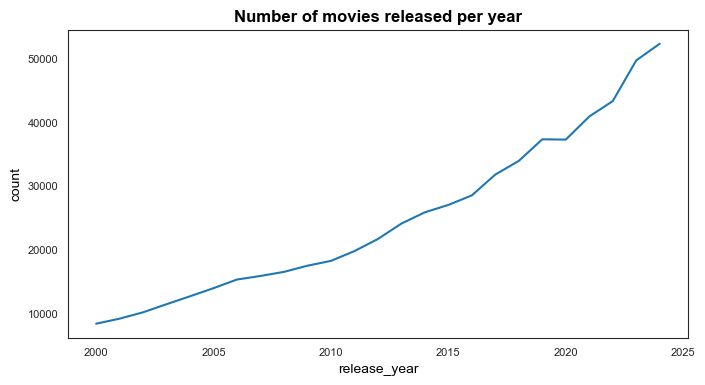

In [14]:
# quick check on evolution of movies released per year before we drop records
temp = pd.DataFrame(
    df_movies_imdb.groupby('release_year').size(),
    columns=['count'])

temp = temp.loc[2000:2024]

sns.lineplot(data=temp, x=temp.index, y='count')
plt.title('Number of movies released per year')
plt.show()

In [15]:
# filter movie dataset
df_movies_imdb_clean = df_movies_imdb[
    (df_movies_imdb.release_year >= 2000) &
    # (df_movies_imdb.adult == False) &
    (df_movies_imdb.original_language == 'en') &
    (df_movies_imdb.imdb_id.notnull()) &
    (df_movies_imdb.poster_path.notnull()) &
    (df_movies_imdb.status == 'Released') &
    (df_movies_imdb.imdb_votes >= 20) &
    (df_movies_imdb.vote_count > 0) &
    (df_movies_imdb.imdb_rating >= 3) &
    # (df_movies_imdb.popularity >= 1) &
    (df_movies_imdb.spoken_languages.str.contains('English'))
    ].copy(deep=True)

df_movies_imdb_clean.shape

(57620, 28)

In [16]:
df_movies_imdb_clean.loc[df_movies_imdb_clean['title'].str.lower().str.contains('it ends with us') == True]

,id,title,vote_average,vote_count,status,revenue,runtime,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes,poster_path,release_year
765670,1079091,It Ends with Us,7.05,1540.00,Released,350993761.00,131.00,25000000.00,tt10655524,en,It Ends with Us,When a woman's first love suddenly reenters he...,12.59,We break the pattern or the pattern breaks us.,"Drama, Romance","Columbia Pictures, Wayfarer Studios, Saks Pict...",United States of America,English,"Kevin McKidd, Daphne Zelle, Brandon Sklenar, M...",Justin Baldoni,Barry Peterson,"Christy Hall, Colleen Hoover","Christy Hall, Blake Lively, Todd Black, John L...","Rob Simonsen, Duncan Blickenstaff",6.40,83176.00,/cSMdFWmajaX4oUMLx7HEDI84GkP.jpg,2024


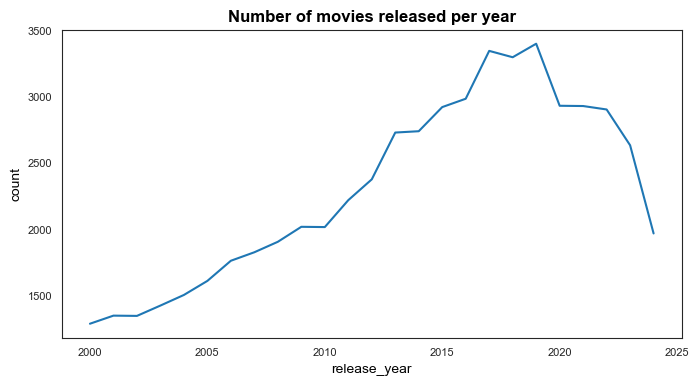

In [17]:
# quick check on evolution movies released per year, before we drop records
temp = pd.DataFrame(
    df_movies_imdb_clean.groupby('release_year').size(),
    columns=['count'])

temp = temp.loc[1990:2024]

sns.lineplot(data=temp, x=temp.index, y='count')
plt.title('Number of movies released per year')
plt.show()

In [18]:
# drop movies that are too short, do this as a separate step otherwise filter is too slow
df_movies_imdb_clean = df_movies_imdb_clean[df_movies_imdb_clean['runtime'] >= 60.0]
df_movies_imdb_clean.shape

(46522, 28)

<a id='imdb_scope'></a>
<span style="color:#7C9E9E; font-size:16px; font-weight:bold">2.1.2 Check Missing values and data types</span>

In [19]:
# which datatypes does the dataset have, and how many missing values can be observed?
df_movies_imdb_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46522 entries, 4 to 1075649
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       46522 non-null  int64  
 1   title                    46522 non-null  object 
 2   vote_average             46522 non-null  float64
 3   vote_count               46522 non-null  float64
 4   status                   46522 non-null  object 
 5   revenue                  46522 non-null  float64
 6   runtime                  46522 non-null  float64
 7   budget                   46522 non-null  float64
 8   imdb_id                  46522 non-null  object 
 9   original_language        46522 non-null  object 
 10  original_title           46522 non-null  object 
 11  overview                 46468 non-null  object 
 12  popularity               46522 non-null  float64
 13  tagline                  24236 non-null  object 
 14  genres                   

In [20]:
# reduce memory footprint by selecting the correct dtypes for numeric columns
df_movies_imdb_clean = reduce_mem_usage(df_movies_imdb_clean)


Triggering memory optimization.......

Memory usage of dataframe is 10.29 MB
Memory usage after optimization is: 7.99 MB
Decreased by 22.4%


In [21]:
# correct datatype to reduce memory usage
# df_movies_imdb_clean['imdb_votes'] = df_movies_imdb_clean['imdb_votes'].astype(int32)
# df_movies_imdb_clean['vote_count'] = df_movies_imdb_clean['imdb_votes'].astype(int32)

**Observation from programming inspection `info()`:**

- There are missing data in some columns let's explore it deeper

##### Missing data in rows

In [22]:
missing_data_in_rows = df_movies_imdb_clean.isna().mean(axis=1) * 100
missing_data_in_rows.describe()

count   46522.00
mean        8.90
std         7.21
min         0.00
25%         3.57
50%         7.14
75%        14.29
max        35.71
dtype: float64

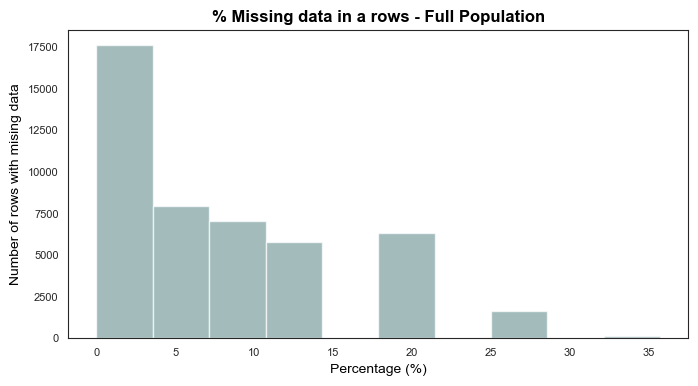

In [23]:
missing_data_in_rows.plot(kind='hist',
                          title='% Missing data in a rows - Full Population',
                          figsize=(8, 4),
                          alpha=0.7,
                          color = seafoam.base_color)
plt.ylabel('Number of rows with mising data')
plt.xlabel('Percentage (%)')
plt.show()

In [24]:
# drop rows with more than 20% missing values
df_movies_imdb_clean = df_movies_imdb_clean.loc[df_movies_imdb_clean.isna().mean(axis=1) < 0.25, :]
df_movies_imdb_clean.shape

(44772, 28)

##### Missing values in columns

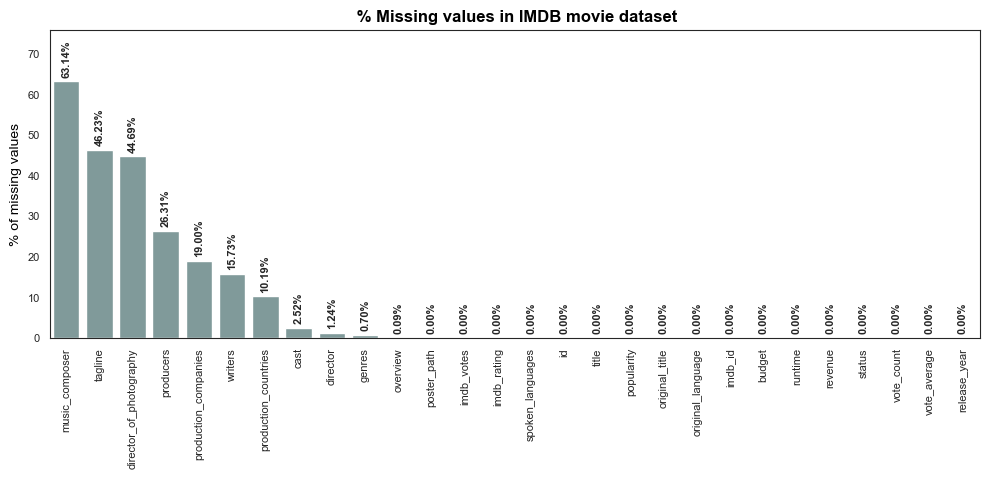

In [25]:
missing_values = round((df_movies_imdb_clean.isna().mean() * 100).sort_values(ascending=False), 2)

fig = plt.figure(figsize=(12,4))
ax = sns.barplot(data=missing_values, color=seafoam.base_color)

# annotate
for c in ax.containers:
    ax.bar_label(c, padding=3, fontsize=8, rotation=90, weight='bold', fmt='%.2f%%')

plt.xticks(rotation=90)
ax.margins(y=0.2)

plt.title(' % Missing values in IMDB movie dataset')
plt.ylabel('% of missing values')
plt.show()

In [26]:
# which kind of movies have no genres?
df_movies_imdb_clean[df_movies_imdb_clean['genres'].isnull()]

,id,title,vote_average,vote_count,status,revenue,runtime,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes,poster_path,release_year
12326,20419,WWE: Allied Powers - The World's Greatest Tag ...,7.10,4.00,Released,0.00,540.00,0.00,tt1461297,en,WWE: Allied Powers - The World's Greatest Tag ...,"Throughout the decades, fans of sports enterta...",1.82,NaN,NaN,WWE Studios,United States of America,English,"Tom Billington, Martin Lunde, James Hines, Kev...",Kevin Dunn,NaN,NaN,NaN,NaN,7.30,63.00,/eTmLxtbyznpfPPCD3XbTAbct3C4.jpg,2009
18514,29899,Claustrophobia,2.70,3.00,Released,0.00,79.00,95000.00,tt0315411,en,Claustrophobia,A serial killer armed with a crossbow pistol i...,1.46,NaN,NaN,"Integration Entertainment, Cassava Films, Gree...",United States of America,English,"Lucas Young, Rachelle Lagnado, Stan Guo, Miche...",Mark Tapio Kines,Bevan Crothers,Mark Tapio Kines,Mark Tapio Kines,Christopher Farrell,3.30,414.00,/gNyLGFOTMvRwbGkrLuFiLAAfHhD.jpg,2003
18933,30470,Gladiator Eroticvs: The Lesbian Warriors,5.10,12.00,Released,0.00,91.00,0.00,tt0256056,en,Gladiator Eroticvs: The Lesbian Warriors,A parody of the big-budget Ridley Scott-helmed...,7.94,NaN,NaN,"Fantasy Bride Productions, E.I. Independent Ci...",United States of America,English,"Raymond Lilienthal, W.C. Ponder, Don Mike, Joh...",John Bacchus,Richard Yankin,"John Bacchus, Joe Ned",NaN,Grisly Labs,3.50,532.00,/qrRDFkkyLR4SUrhQwMtmSILXq8I.jpg,2001
21201,33827,The Graffiti Artist,5.60,25.00,Released,0.00,80.00,0.00,tt0402223,en,The Graffiti Artist,"Adrift in the lush, nocturnal urban landscape ...",2.58,NaN,NaN,NaN,United States of America,English,"Luke Cook, Ruben Bansie-Snellman, Pepper Fajans",James Bolton,NaN,James Bolton,James Bolton,NaN,6.10,819.00,/kKyp4lgIhI8pNGZj29Y8xH8vR1A.jpg,2004
21806,34988,Who Do You Love,1.00,1.00,Released,0.00,92.00,0.00,tt1186795,en,Who Do You Love,Who Do You Love is the life story of legendary...,0.28,NaN,NaN,NaN,NaN,English,"Gavin C. Lewis Sr., Hunter McGregor, Marika Do...",Jerry Zaks,David Franco,"Robert Conte, Peter Wortmann","Andrea Baynes, Les Alexander, Gideon Amir, Den...",Jeff Beal,6.00,181.00,/n2G00q7txMBtVkLN3lWTTOlX58b.jpg,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945320,1303875,Chestnut vs. Kobayashi: Unfinished Beef,3.50,2.00,Released,0.00,71.00,0.00,tt32633891,en,Chestnut vs. Kobayashi: Unfinished Beef,16-time hot dog– eating champion Joey Chestnut...,2.37,NaN,NaN,NaN,United States of America,English,"Takeru Kobayashi, Joey Chestnut, Cari Champion...",Ryan Polito,Malcolm Serrette,NaN,"Niki Usbay McDonald, Nicole Lucas Haimes, J.B....",NaN,5.10,256.00,/jDPJhmytwYKMnq72AIunNsTE1LF.jpg,2024
952039,1311446,Hit Em Hard: The Story of Zaina Juliette,10.00,1.00,Released,50000000.00,86.00,0.00,tt3865434,en,Hit Em Hard: The Story of Zaina Juliette,To achieve your dream and passion in a powerfu...,0.66,To achieve your dream and passion in a powerfu...,NaN,"ZTraxx Music Group, Bungalo Records, Universal...",NaN,English,"Black Jack Cross - K9, Tina Lynn Turner, Sebas...",NaN,NaN,NaN,Tina Lynn Turner,NaN,8.30,20.00,/mZBEkO3qwSG3WZBYffO3h77hpWW.jpg,2014
960318,1320648,Broken Innocence,5.00,2.00,Released,0.00,112.00,57000.00,tt28259039,en,Broken Innocence,When a young girl suffers years of horrendous ...,0.23,When a cycle of abuse finally catches up to th...,NaN,"Angela Joseph Productions, A Cut to the Chase ...",United States of America,English,"Kiley Opsal, Corel Garlock, Jonni Shandor, Her...",Chase Dudley,NaN,"Charlie Brady, Chase Dudley","Sheri Davis, Chase Dudley",NaN,5.10,344.00,/jzRa8jyQD3O80Zq5X8cSu9laTkc.jpg,2024
1029450,1401599,AEW Revolution,8.50,3.00,Released,0.00,245.00,0.00,tt34998107,en,AEW Revolution,The 2025 Revolution was a professional wrestli...,5.05,NaN,NaN,All 

In [27]:
cols_to_drop = missing_values >= 50
missing_values = missing_values[cols_to_drop]
missing_values = missing_values.index.values.tolist()
print('Columns to drop: {}'.format(missing_values))

Columns to drop: ['music_composer']


In [28]:
# drop columns with missing values exceeding 40%
df_movies_imdb_clean.drop(missing_values, axis=1, inplace=True)
df_movies_imdb_clean.shape

(44772, 27)

<a id='imdb_unique'></a>
<span style="color:#7C9E9E; font-size:16px; font-weight:bold">2.1.3 Check Unique Values</span>

In [29]:
# how many unique values does each column of the dataset have?
df_movies_imdb_clean.nunique()

id                         44772
title                      42501
vote_average                1138
vote_count                  2887
status                         1
revenue                     6621
runtime                      257
budget                      1007
imdb_id                    44767
original_language              1
original_title             42520
overview                   44721
popularity                  6928
tagline                    23676
genres                      4122
production_companies       28842
production_countries        2101
spoken_languages            1310
cast                       43111
director                   23942
director_of_photography     8812
writers                    30444
producers                  30960
imdb_rating                   69
imdb_votes                 12021
poster_path                44768
release_year                  26
dtype: int64

**Observation from programming inspection `nunique()`:**
    
- columns seems to contain a lot of unique values. To

In [30]:
# show unique values for some columns
print('\nUNIQUE VALUES FOR COLUMNS: \n')
cols = ['status', 'release_year']
for col in cols:
    print('Unique values for column {}: \n {} \n'.format(col, df_movies_imdb_clean[col].sort_values().unique()))


UNIQUE VALUES FOR COLUMNS: 

Unique values for column status: 
 ['Released'] 

Unique values for column release_year: 
 [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025] 



In [31]:
# number of different genres
genres = []
genres_unique = []
for val in df_movies_imdb_clean['genres']:
    try:
        genres.extend(val.split(', '))
    except AttributeError:
        pass

genres_unique = set(genres)
print('The number of unique genres is: {}'.format(len(genres_unique)))
print(genres_unique)

The number of unique genres is: 19
{'Family', 'Crime', 'Action', 'History', 'Adventure', 'Thriller', 'Documentary', 'Western', 'Horror', 'TV Movie', 'Drama', 'Science Fiction', 'Comedy', 'Romance', 'Fantasy', 'Mystery', 'War', 'Animation', 'Music'}


In [32]:
# number of different directors
director = []
director_unique = []
for val in df_movies_imdb_clean['director']:
    try:
        director.extend(val.split(', '))
    except AttributeError:
        pass

director_unique = set(director)
print('The number of unique directors is: {}'.format(len(director_unique)))
Counter(director).most_common(20)

The number of unique directors is: 26227


[('Kevin Dunn', 252),
 ('David DeCoteau', 78),
 ('Fred Olen Ray', 75),
 ('Terry Ingram', 70),
 ('Michael Feifer', 66),
 ('Vince McMahon', 57),
 ('Jim Wynorski', 51),
 ('Ron Oliver', 51),
 ('Steven R. Monroe', 48),
 ('Damián Romay', 45),
 ('Ryan Polito', 43),
 ('Kevin Fair', 43),
 ('Jason Bourque', 40),
 ('Doug Campbell', 40),
 ('Charles Band', 39),
 ('Tyler Perry', 39),
 ('Mark Jean', 38),
 ('Peter Sullivan', 38),
 ('Jake Helgren', 38),
 ('Hamish Hamilton', 37)]

In [33]:
# number of different production companies
production_company = []
production_company_unique = []
for val in df_movies_imdb_clean['production_companies']:
    try:
        production_company.extend(val.split(', '))
    except AttributeError:
        pass

production_company_unique = set(production_company)
print('The number of unique production companies is: {}'.format(len(production_company_unique)))
Counter(production_company).most_common(20)

The number of unique production companies is: 29698


[('Lifetime', 459),
 ('Universal Pictures', 424),
 ('BBC', 409),
 ('Reel One Entertainment', 399),
 ('Warner Bros. Pictures', 352),
 ('Lionsgate', 333),
 ('MarVista Entertainment', 313),
 ('Columbia Pictures', 289),
 ('Paramount Pictures', 270),
 ('HBO Documentary Films', 255),
 ('BBC Film', 253),
 ('World Wrestling Entertainment (WWE)', 243),
 ('Hallmark Media', 236),
 ('20th Century Fox', 230),
 ('Film4 Productions', 228),
 ('Front Street Pictures', 219),
 ('Voltage Pictures', 217),
 ('Johnson Production Group', 217),
 ('Metro-Goldwyn-Mayer', 192),
 ('Walt Disney Pictures', 190)]

In [34]:
# number of different writers
writers = []
writers_unique = []
for val in df_movies_imdb_clean['writers']:
    try:
        writers.extend(val.split(', '))
    except AttributeError:
        pass

writers_unique = set(writers)
print('The number of unique production companies is: {}'.format(len(writers_unique)))
Counter(writers).most_common(20)

The number of unique production companies is: 38207


[('Peter Sullivan', 109),
 ('William Shakespeare', 106),
 ('Jeffrey Schenck', 89),
 ('Paul Lévesque', 77),
 ('Stephanie McMahon', 72),
 ('Barbara Kymlicka', 64),
 ('Christine Conradt', 56),
 ('Michael Seitz', 55),
 ('Bruce Prichard', 55),
 ('Vince McMahon', 54),
 ('Bob Kane', 50),
 ('Adam Rockoff', 50),
 ('Teena Booth', 49),
 ('Jack Kirby', 47),
 ('Rolfe Kanefsky', 47),
 ('Stan Lee', 45),
 ('Marcy Holland', 44),
 ('Fred Olen Ray', 43),
 ('Mark Monroe', 42),
 ('Jake Helgren', 42)]

In [35]:
# number of different writers
cast = []
cast_unique = []
for val in df_movies_imdb_clean['cast']:
    try:
        cast.extend(val.split(', '))
    except AttributeError:
        pass

cast_unique = set(cast)
print('The number of unique actors is: {}'.format(len(cast_unique)))
Counter(cast).most_common(20)

The number of unique actors is: 318720


[('Jr.', 319),
 ('Eric Roberts', 249),
 ('John Cena', 207),
 ('Randy Orton', 183),
 ('Danny Trejo', 175),
 ('Glenn Jacobs', 162),
 ('Paul Wight', 155),
 ('Adam Copeland', 149),
 ('Mike Mizanin', 137),
 ('Mark Calaway', 135),
 ('Chris Irvine', 133),
 ('Paul Lévesque', 132),
 ('Vivica A. Fox', 131),
 ('Michael Madsen', 130),
 ('Óscar Gutiérrez', 130),
 ('Lochlyn Munro', 128),
 ('Frank Welker', 128),
 ('Lloyd Kaufman', 126),
 ('Grey DeLisle', 122),
 ('Keith David', 119)]

**Observation from programming inspection `unique()`:**
- columns like `cast`, `writers`, `production_companies` and `director` have too many unique values to include as-is in modelling

<a id='imdb_unique'></a>
<span style="color:#7C9E9E; font-size:16px; font-weight:bold">2.1.4 Duplicate checks</span>

In [36]:
# Are any rows duplicated?
df_movies_imdb_clean.duplicated().sum()

0

In [37]:
df_movies_imdb_clean['imdb_id'].duplicated().sum()

5

In [38]:
df_movies_imdb_clean['id'].duplicated().sum()

0

In [39]:
df_movies_imdb_clean.drop_duplicates(['imdb_id'], inplace=True)
df_movies_imdb_clean.shape

(44767, 27)

In [40]:
assert df_movies_imdb_clean.imdb_id.duplicated().sum() == 0

**Observation of duplications:**

- there are only a few records with imdbId duplicated, which will be our main identifier

<a id='movielens_links'></a>
<span style="color:#7C9E9E; font-size:20px; font-weight:bold">2.2 Assess and Clean MovieLens Links</span>

The `links.csv` dataset contains movie id mapping
with which we can link MovieLens and IMDB data together.

In [41]:
# visual inspection of MovieLens `links.csv` file
cols_of_interest = ['movielens_id', 'imdbId']
path = os.path.join('..', path_links_raw)

df_movielens_links = pd.read_csv(
    path,
    usecols=cols_of_interest,
    names=cols_of_interest,
    header=0,
    dtype='int32',
)

df_movielens_links.sample(5)

,movielens_id,imdbId
27746,129832,1210117
69515,223936,8068826
4942,5047,240468
12166,58146,1001562
18125,94762,35737


In [42]:
df_movielens_links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87585 entries, 0 to 87584
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   movielens_id  87585 non-null  int32
 1   imdbId        87585 non-null  int32
dtypes: int32(2)
memory usage: 684.4 KB


<a id='movielens_unique'></a>
<span style="color:#7C9E9E; font-size:16px; font-weight:bold">2.2.1 Missing values</span>

In [43]:
df_movielens_links.isna().sum()

movielens_id    0
imdbId          0
dtype: int64

<a id='movielens_unique'></a>
<span style="color:#7C9E9E; font-size:16px; font-weight:bold">2.2.2 Duplicate checks</span>

In [44]:
# make sure imbdId is not duplicated
assert df_movielens_links.imdbId.duplicated().sum() == 0

In [45]:
# make sure there are no duplicated records
assert df_movielens_links.duplicated().sum() == 0

In [46]:
# make sure there are no duplicated records
assert df_movielens_links.movielens_id.duplicated().sum() == 0



Let's test it's validity,
filter it to movies in-scope and create a clean version.

In [47]:
# check the format of column `imdb_id` in the movies dataset
cols_filter = ['id', 'title', 'imdb_id']
df_movies_imdb_clean[df_movies_imdb_clean['title'].str.contains('Hobbit')][cols_filter]

,id,title,imdb_id
32966,49051,The Hobbit: An Unexpected Journey,tt0903624
39294,57158,The Hobbit: The Desolation of Smaug,tt1170358
80402,122917,The Hobbit: The Battle of the Five Armies,tt2310332
1068777,1449189,J.R.R. Tolkien's The Hobbit,tt13749944


In [48]:
# Double check if link dataset really works, can it link movies together?
# Let's use `imdb_id` for the hobbit and see if it exists in links dataset
df_movielens_links[df_movielens_links['imdbId'] == 903624]

,movielens_id,imdbId
18958,98809,903624


In [49]:
# Now let's confirm that the movie in MovieLens is the same Hobbit movie...
path = os.path.join('..', path_movielens_movies)
df_movielens = pd.read_csv(path)
df_movielens[df_movielens['movieId'] == 98809]

,movieId,title,genres
18958,98809,"Hobbit: An Unexpected Journey, The (2012)",Adventure|Fantasy|IMAX


**Observation:**

* `links.csv` dataset is a greate integrator of datasets for TMDB, IMDB and MovieLens
* columns `imdb_id` are `imdbId` are inconsistent between the two datasets, tt0903624 vs 903624

In [50]:
# add a column to convert imdb_id into an integer so we can join the tables
cols_filter = ['id', 'title', 'imdb_id', 'imdbId']
df_movies_imdb_clean['imdbId'] = df_movies_imdb_clean['imdb_id'].str[2:].astype('int32')
df_movies_imdb_clean[df_movies_imdb_clean['title'].str.contains('Hobbit')][cols_filter]

,id,title,imdb_id,imdbId
32966,49051,The Hobbit: An Unexpected Journey,tt0903624,903624
39294,57158,The Hobbit: The Desolation of Smaug,tt1170358,1170358
80402,122917,The Hobbit: The Battle of the Five Armies,tt2310332,2310332
1068777,1449189,J.R.R. Tolkien's The Hobbit,tt13749944,13749944


In [51]:
# only keep records in the `links`
# dataset that are in-scope in our main movie dataset
print('Number of records before the merge {}'.format(df_movielens_links.shape))
df_movielens_links = df_movielens_links.merge(df_movies_imdb_clean, on='imdbId', how='inner')[cols_of_interest]
print('Number of records after merge {}'.format(df_movielens_links.shape))
print('Number of records in movie dataset {}'.format(df_movies_imdb_clean.shape))

Number of records before the merge (87585, 2)
Number of records after merge (24394, 2)
Number of records in movie dataset (44767, 28)


**Observation**: Over 20k movies are not present in the MovieLens dataset, perhaps not the best data source

<a id='movielens_ratings'></a>
<span style="color:#7C9E9E; font-size:20px; font-weight:bold">2.3 Assess and Clean MovieLens Ratings</span>

In [52]:
# visual inspection of MovieLens Ratings dataframe
dtypes = {'user_id': 'int32', 'movielens_id': 'int32', 'rating': 'float16'}
column_names = ['user_id', 'movielens_id', 'rating', 'timestamp']
path = os.path.join('..', path_ratings_raw)
df_movielens_ratings = pd.read_csv(path, usecols=column_names, names=column_names, header=0, dtype=dtypes)
df_movielens_ratings['timestamp'] =  pd.to_datetime(df_movielens_ratings['timestamp'], unit='s')
df_movielens_ratings.sample(5)

,user_id,movielens_id,rating,timestamp
29845364,187210,250010,4.00,2021-06-13 16:05:41
20558780,128710,364,5.00,2000-03-13 03:00:12
4835059,30197,140809,5.00,2020-06-28 23:51:49
16474484,103207,2918,3.00,2022-06-06 12:29:17
18960913,118674,3527,3.00,2003-03-08 14:35:58


In [53]:
df_movielens_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000204 entries, 0 to 32000203
Data columns (total 4 columns):
 #   Column        Dtype         
---  ------        -----         
 0   user_id       int32         
 1   movielens_id  int32         
 2   rating        float16       
 3   timestamp     datetime64[ns]
dtypes: datetime64[ns](1), float16(1), int32(2)
memory usage: 549.3 MB


In [54]:
# First, let's reduce ratings to include only movies present in the movie dataset
ratings_index = df_movielens_links['movielens_id'].tolist()
df_movielens_ratings = df_movielens_ratings.merge(df_movielens_links, on='movielens_id', how='inner')
df_movielens_ratings.shape

(12646425, 5)

In [55]:
df_movielens_ratings.head()

,user_id,movielens_id,rating,timestamp,imdbId
0,3,3578,5.00,2004-05-13 21:58:54,172495
1,3,3623,3.00,2004-05-13 21:54:24,120755
2,3,3753,5.00,2004-05-13 21:58:26,187393
3,3,3793,3.00,2004-05-13 21:59:09,120903
4,3,3826,3.00,2004-05-13 21:54:41,164052


In [56]:
# what is the range of timestamps on the ratings?
df_movielens_ratings.timestamp.min(), df_movielens_ratings.timestamp.max()

(Timestamp('1999-08-19 01:43:47'), Timestamp('2023-10-13 02:28:18'))

In [57]:
# Does a user rate a movie more than once?
assert df_movielens_ratings[['user_id', 'movielens_id']].duplicated().sum() == 0

In [58]:
# Before we clean up the dataset, how many unique users and movies do we have?
df_movielens_ratings.nunique()

user_id           151217
movielens_id       24122
rating                10
timestamp       11693176
imdbId             24122
dtype: int64

In [59]:
# What is the distribution of how many movies a user interacts within the dataset?
df_users_cnt = pd.DataFrame(
    df_movielens_ratings.groupby('user_id').size(), columns=['count']
).sort_values('count', ascending=False)

df_users_cnt.describe([0.05, 0.25, 0.5, 0.75, 0.99])

,count
count,151217.00
mean,83.63
std,155.93
min,1.00
5%,3.00
25%,13.00
50%,34.00
75%,88.00
99%,739.00
max,8346.00


In [60]:
# What is the distribution of how many times a movie gets rated?
df_movies_cnt = pd.DataFrame(
    df_movielens_ratings.groupby('movielens_id').size(), columns=['count']
)

df_movies_cnt.describe([0.05, 0.25, 0.5, 0.75, 0.99])

,count
count,24122.00
mean,524.27
std,2676.69
min,1.00
5%,1.00
25%,2.00
50%,9.00
75%,69.00
99%,12162.07
max,73122.00


#### <a id='ratings_filter'></a>
<span style="color:#7C9E9E; font-size:16px; font-weight:bold">2.3.1 Filter MovieLens dataset</span>

In [61]:
print('Ratings dataset shape before filtering: {}'.format(df_movielens_ratings.shape))
# popular movie filter - a movie got rated at least 10 times in MovieLens
df_movies_cnt = pd.DataFrame(
    df_movielens_ratings.groupby('movielens_id').size(), columns=['count']
)
popular_movies = list(set(df_movies_cnt.query('count > 10').index))
movies_filter = df_movielens_ratings['movielens_id'].isin(popular_movies).values

# active user filter - user rated at least 20 movies in MovieLens
df_users_cnt = pd.DataFrame(df_movielens_ratings.groupby('user_id').size(), columns=['count'])
active_users = list(set(df_users_cnt.query('count > 20').index))
users_filter = df_movielens_ratings['user_id'].isin(active_users).values

# filter the data
df_movielens_ratings = df_movielens_ratings[movies_filter & users_filter]
print('Ratings dataset shape after filtering: {}'.format(df_movielens_ratings.shape))

del df_movies_cnt, df_users_cnt

Ratings dataset shape before filtering: (12646425, 5)
Ratings dataset shape after filtering: (12078741, 5)


In [62]:
# check again unique values of users and movies after clean-up
print(df_movielens_ratings.nunique())

user_id            96699
movielens_id       11583
rating                10
timestamp       11171455
imdbId             11583
dtype: int64


In [63]:
# double-check unique values and distribution of ratings
df_movielens_ratings.rating.value_counts()

rating
4.00    2870009
3.50    2156825
3.00    1958510
4.50    1352446
5.00    1332039
2.50     868254
2.00     695841
1.00     302476
1.50     273663
0.50     268678
Name: count, dtype: int64

#### <a id='ratings_filter'></a>
<span style="color:#7C9E9E; font-size:16px; font-weight:bold">2.3.2 Enrich movies dataset with latest rating timestamp</span>

In [64]:
df_movies_imdb_clean.shape

(44767, 28)

In [65]:
temp = pd.DataFrame(df_movielens_ratings.groupby('imdbId')['timestamp'].max())
temp.columns = ['last_rating_timestamp']
df_movies_imdb_clean = df_movies_imdb_clean.merge(temp, on='imdbId', how='left')
del temp
df_movies_imdb_clean.head()

,id,title,vote_average,vote_count,status,revenue,runtime,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,cast,director,director_of_photography,writers,producers,imdb_rating,imdb_votes,poster_path,release_year,imdbId,last_rating_timestamp
0,8,Life in Loops (A Megacities RMX),7.50,27.00,Released,0.00,80.00,42000.00,tt0825671,en,Life in Loops (A Megacities RMX),Timo Novotny labels his new project an experim...,3.20,A Megacities remix.,Documentary,inLoops,Austria,"English, हिन्दी, 日本語, Pусский, Español",NaN,Timo Novotny,Wolfgang Thaler,"Michael Glawogger, Timo Novotny","Ulrich Gehmacher, Timo Novotny",8.20,284.00,/7ln81BRnPR2wqxuITZxEciCe1lc.jpg,2006,825671,NaT
1,12,Finding Nemo,7.82,19552.00,Released,940335552.00,100.00,94000000.00,tt0266543,en,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp...",18.08,There are 3.7 trillion fish in the ocean. They...,"Animation, Family",Pixar,United States of America,English,"Albert Brooks, Bob Bergen, Bobby Block, Ellen ...",Andrew Stanton,"Sharon Calahan, Jeremy Lasky","Blake Tucker, Bob Peterson, David Reynolds, Ad...","John Lasseter, Graham Walters",8.20,1154759.00,/eHuGQ10FUzK1mdOY69wF5pGgEf5.jpg,2003,266543,2023-10-12 20:27:03
2,16,Dancer in the Dark,7.90,1832.00,Released,40061152.00,140.00,12500000.00,tt0168629,en,Dancer in the Dark,"Selma, a Czech immigrant on the verge of blind...",2.34,You don't need eyes to see.,"Drama, Crime","Zentropa Entertainments, DR, SVT Drama, ARTE, ...","Denmark, Finland, France, Germany, Iceland, Ne...",English,"Marianne Bengtsson, Britt Bendixen, David Mors...",Lars von Trier,Robby Müller,"Lars von Trier, Sjón","Vibeke Windeløv, Leo Pescarolo, Peter Aalbæk J...",7.90,120222.00,/9rsivF4sWfmBzrNr4LPu6TNJhXX.jpg,2000,168629,2023-10-09 20:56:26
3,17,The Dark,5.70,277.00,Released,6593579.00,87.00,0.00,tt0411267,en,The Dark,"In an attempt to pull her family together, Adè...",6.28,One of the living for one of the dead.,"Horror, Thriller, Mystery","Constantin Film, Impact Pictures, Isle of Man ...","Germany, United Kingdom","Cymraeg, English","Robin Griffith, Maurice Roëves, Maria Bello, S...",John Fawcett,Christian Sebaldt,"Simon Maginn, Stephen Massicotte, Rory Gilmartin","Steve Christian, Paul W. S. Anderson, Robert K...",5.30,11669.00,/h6gCVAzjFLhzkffv2VZO1RgVCBt.jpg,2005,411267,2022-12-18 10:06:20
4,20,My Life Without Me,6.04,470.00,Released,12300000.00,106.00,2500000.00,tt0314412,en,My Life Without Me,A fatally ill mother with only two months to l...,11.25,What you are… is what you leave behind.,"Drama, Romance","El Deseo, Milestone Productions","Canada, Spain",English,"Leonor Watling, Kenya Jo Kennedy, Jessica Amle...",Isabel Coixet,Jean-Claude Larrieu,"Isabel Coixet, Nanci Kincaid","Pedro Almodóvar, Esther García, Agustín Almodó...",7.40,26197.00,/pFEtVPW88pWflYV84UFL0h1iJr3.jpg,2003,314412,2023-09-03 21:54:57


In [66]:
# let's test if the timestamp was added correctly to the main movies dataset
cols_filter = ['imdbId', 'title', 'last_rating_timestamp']
df_movies_imdb_clean.loc[df_movies_imdb_clean['title'].str.contains('Hobbit:') == True][cols_filter]

,imdbId,title,last_rating_timestamp
7526,903624,The Hobbit: An Unexpected Journey,2023-10-12 22:35:16
8459,1170358,The Hobbit: The Desolation of Smaug,2023-10-12 16:03:28
12962,2310332,The Hobbit: The Battle of the Five Armies,2023-10-12 16:03:30


In [67]:
df_movielens_ratings[df_movielens_ratings['imdbId'] == 903624].sort_values('timestamp', ascending=False)[:1]

,user_id,movielens_id,rating,timestamp,imdbId
1216305,19363,98809,3.00,2023-10-12 22:35:16,903624


In [68]:
df_movielens_ratings[df_movielens_ratings['imdbId'] == 2310332].sort_values('timestamp', ascending=False)[:1]

,user_id,movielens_id,rating,timestamp,imdbId
3952606,62994,118696,2.50,2023-10-12 16:03:30,2310332


<a id='movielens_tags'></a>
<span style="color:#7C9E9E; font-size:20px; font-weight:bold">2.4 Assess and Clean MovieLens Tags</span>

Build a new table to used for NLP content-based recommendations.
Add to this table:
- tags from movielens
- texts fields from IMDB movies like the title, overview, tagline, genres, directors, producers, cast, production_companies, tags

In [69]:
# visual inspection of MovieLens `tags.csv` file
path = os.path.join('..', path_tags_raw)
cols = ['user_id', 'movielens_id', 'tag', 'timestamp']
df_movielens_tags = pd.read_csv(path, names=cols, header=0)
df_movielens_tags['timestamp'] =  pd.to_datetime(df_movielens_tags['timestamp'], unit='s')
df_movielens_tags['tag'] =  df_movielens_tags['tag'].str.lower()
df_movielens_tags[df_movielens_tags['movielens_id'] == 1].sample(10)

,user_id,movielens_id,tag,timestamp
593926,78203,1,disney,2019-05-16 20:51:39
598235,78213,1,chased by a dog,2021-02-04 19:45:43
1705843,128399,1,cgi classic,2015-10-07 07:59:36
1328683,79208,1,tom hanks,2020-05-03 02:15:09
598485,78213,1,van,2021-02-04 19:45:43
63281,8509,1,children,2010-09-15 22:14:29
1932210,156071,1,children,2018-08-09 21:30:31
1342017,81065,1,disney,2009-05-07 18:37:12
598313,78213,1,frustration,2021-02-04 19:45:45
1551343,108578,1,computer animation,2008-03-28 00:07:23


In [70]:
df_movielens_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000072 entries, 0 to 2000071
Data columns (total 4 columns):
 #   Column        Dtype         
---  ------        -----         
 0   user_id       int64         
 1   movielens_id  int64         
 2   tag           object        
 3   timestamp     datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 61.0+ MB


In [71]:
df_movielens_tags.nunique()

user_id           15848
movielens_id      51323
tag              132171
timestamp       1291250
dtype: int64

In [72]:
# When were tags created?
df_movielens_tags.timestamp.min(), df_movielens_tags.timestamp.max()

(Timestamp('2005-12-24 13:00:10'), Timestamp('2023-10-12 23:56:23'))

In [73]:
# get rid of duplicate tags
# df_movielens_tags = df_movielens_tags.drop_duplicates(subset=['movielens_id', 'tag'])
# df_movielens_tags[df_movielens_tags['movielens_id'] == 1]

In [74]:
# remove spaces from tags
# df_movielens_tags['tag'] = df_movielens_tags['tag'].str.replace(' ', '')
# df_movielens_tags[df_movielens_tags['movielens_id'] == 1].sample(50)

In [75]:
# create a tag summary per movie
df_tag_summary = df_movielens_tags.groupby('movielens_id')['tag'].apply(list).str.join(' ').to_frame().reset_index()
df_tag_summary.head()

,movielens_id,tag
0,1,children disney animation children disney disn...
1,2,robin williams fantasy robin williams time tra...
2,3,comedinha de velhinhos engraãƒâ§ada comedinha ...
3,4,characters slurs based on novel or book chick ...
4,5,fantasy pregnancy remake family steve martin s...


In [76]:
# Filter tags to movies in scope, add IMDB movie id, and drop the movielens_id
df_tag_summary = df_tag_summary.merge(df_movielens_links, on='movielens_id', how='inner')
del df_tag_summary['movielens_id']
df_tag_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15435 entries, 0 to 15434
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tag     15432 non-null  object
 1   imdbId  15435 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 181.0+ KB


In [77]:
# add all movie text columns
text_cols = ['imdbId', 'title', 'overview', 'tagline', 'genres', 'director', 'producers',
             'cast', 'production_companies']
df_tag_summary = df_movies_imdb_clean[text_cols].merge(df_tag_summary, on='imdbId', how='left')
df_tag_summary = df_tag_summary.fillna('')
df_tag_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44767 entries, 0 to 44766
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   imdbId                44767 non-null  int32 
 1   title                 44767 non-null  object
 2   overview              44767 non-null  object
 3   tagline               44767 non-null  object
 4   genres                44767 non-null  object
 5   director              44767 non-null  object
 6   producers             44767 non-null  object
 7   cast                  44767 non-null  object
 8   production_companies  44767 non-null  object
 9   tag                   44767 non-null  object
dtypes: int32(1), object(9)
memory usage: 3.2+ MB


In [78]:
# strip spaces from people names
# cols = ['director', 'producers', 'cast', 'production_companies']
# df_tag_summary[cols] = df_tag_summary[cols].apply(lambda x: x.str.lower().str.replace(' ', ''))
# df_tag_summary.sample(5)

In [79]:
text_cols = ['title', 'overview', 'tagline', 'genres', 'director', 'producers',
             'cast', 'production_companies', 'tag']
df_tag_summary['all_texts'] = df_tag_summary[text_cols].agg(' '.join, axis=1)

In [80]:
# df_tag_summary.drop(text_cols, axis=1, inplace=True)

In [81]:
df_tag_summary.head()

,imdbId,title,overview,tagline,genres,director,producers,cast,production_companies,tag,all_texts
0,825671,Life in Loops (A Megacities RMX),Timo Novotny labels his new project an experim...,A Megacities remix.,Documentary,Timo Novotny,"Ulrich Gehmacher, Timo Novotny",,inLoops,,Life in Loops (A Megacities RMX) Timo Novotny ...
1,266543,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp...",There are 3.7 trillion fish in the ocean. They...,"Animation, Family",Andrew Stanton,"John Lasseter, Graham Walters","Albert Brooks, Bob Bergen, Bobby Block, Ellen ...",Pixar,children pixar predictable too cute animals an...,"Finding Nemo Nemo, an adventurous young clownf..."
2,168629,Dancer in the Dark,"Selma, a Czech immigrant on the verge of blind...",You don't need eyes to see.,"Drama, Crime",Lars von Trier,"Vibeke Windeløv, Leo Pescarolo, Peter Aalbæk J...","Marianne Bengtsson, Britt Bendixen, David Mors...","Zentropa Entertainments, DR, SVT Drama, ARTE, ...",bjork cathartic great ending great music sad t...,"Dancer in the Dark Selma, a Czech immigrant on..."
3,411267,The Dark,"In an attempt to pull her family together, Adè...",One of the living for one of the dead.,"Horror, Thriller, Mystery",John Fawcett,"Steve Christian, Paul W. S. Anderson, Robert K...","Robin Griffith, Maurice Roëves, Maria Bello, S...","Constantin Film, Impact Pictures, Isle of Man ...",afterlife british ghosts to see: horror adoles...,The Dark In an attempt to pull her family toge...
4,314412,My Life Without Me,A fatally ill mother with only two months to l...,What you are… is what you leave behind.,"Drama, Romance",Isabel Coixet,"Pedro Almodóvar, Esther García, Agustín Almodó...","Leonor Watling, Kenya Jo Kennedy, Jessica Amle...","El Deseo, Milestone Productions",perrot library canada isabel coixet terminal i...,My Life Without Me A fatally ill mother with o...


In [82]:
# add tags to movie content dataset
# df_movies_imdb_clean = df_movies_imdb_clean.merge(df_tag_summary, on='imdbId', how='left')

<a id='imdb_extra'></a>
<span style="color:#7C9E9E; font-size:20px; font-weight:bold">2.5 Get extra IMDB data</span>

Dataset has the same data as IMDB/TMDB dataset, but with additional interesting columns

In [101]:
path = os.path.join('..', path_imdb_raw_extra)
cols_of_interest = ['imdb_id', 'backdrop_path', 'homepage', 'Star1', 'Star2', 'Star3', 'Star4']
df_movies_imdb_extra = pd.read_csv(
    path,
    usecols=cols_of_interest,
)

df_movies_imdb_extra.columns = df_movies_imdb_extra.columns.str.lower()
df_movies_imdb_extra.head()

,backdrop_path,homepage,imdb_id,star1,star2,star3,star4
0,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,https://www.warnerbros.com/movies/inception,tt1375666,Leonardo DiCaprio,Joseph Gordon-Levitt,Elliot Page,Ken Watanabe
1,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,http://www.interstellarmovie.net/,tt0816692,Matthew McConaughey,Anne Hathaway,Jessica Chastain,Mackenzie Foy
2,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,https://www.warnerbros.com/movies/dark-knight/,tt0468569,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine
3,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,https://www.avatar.com/movies/avatar,tt0499549,Sam Worthington,Zoe Saldana,Sigourney Weaver,Michelle Rodriguez
4,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,https://www.marvel.com/movies/the-avengers,tt0848228,Robert Downey Jr.,Chris Evans,Scarlett Johansson,Jeremy Renner


In [84]:
# check of null values in id column
df_movies_imdb_extra.imdb_id.isna().sum()

482891

In [85]:
# drop records where id is null
df_movies_imdb_extra.dropna(subset=['imdb_id'], inplace=True)

In [86]:
# convert imdb_id to integer to merge with the main movie dataset later
df_movies_imdb_extra['imdbId'] = df_movies_imdb_extra['imdb_id'].str[2:].astype('int32')
del df_movies_imdb_extra['imdb_id']
df_movies_imdb_extra = df_movies_imdb_extra.drop_duplicates(['imdbId'])

In [87]:
# add extra columns to IMDB dataset
df_movies_imdb_clean = df_movies_imdb_clean.merge(df_movies_imdb_extra, on='imdbId', how='left')
df_movies_imdb_clean.head()

,id,title,vote_average,vote_count,status,revenue,runtime,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,cast,director,director_of_photography,writers,producers,imdb_rating,imdb_votes,poster_path,release_year,imdbId,last_rating_timestamp,homepage,star1,star2,star3,star4
0,8,Life in Loops (A Megacities RMX),7.50,27.00,Released,0.00,80.00,42000.00,tt0825671,en,Life in Loops (A Megacities RMX),Timo Novotny labels his new project an experim...,3.20,A Megacities remix.,Documentary,inLoops,Austria,"English, हिन्दी, 日本語, Pусский, Español",NaN,Timo Novotny,Wolfgang Thaler,"Michael Glawogger, Timo Novotny","Ulrich Gehmacher, Timo Novotny",8.20,284.00,/7ln81BRnPR2wqxuITZxEciCe1lc.jpg,2006,825671,NaT,http://lifeinloops.com,NaN,NaN,NaN,NaN
1,12,Finding Nemo,7.82,19552.00,Released,940335552.00,100.00,94000000.00,tt0266543,en,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp...",18.08,There are 3.7 trillion fish in the ocean. They...,"Animation, Family",Pixar,United States of America,English,"Albert Brooks, Bob Bergen, Bobby Block, Ellen ...",Andrew Stanton,"Sharon Calahan, Jeremy Lasky","Blake Tucker, Bob Peterson, David Reynolds, Ad...","John Lasseter, Graham Walters",8.20,1154759.00,/eHuGQ10FUzK1mdOY69wF5pGgEf5.jpg,2003,266543,2023-10-12 20:27:03,http://movies.disney.com/finding-nemo,Lee Unkrich,Albert Brooks,Ellen DeGeneres,Alexander Gould
2,16,Dancer in the Dark,7.90,1832.00,Released,40061152.00,140.00,12500000.00,tt0168629,en,Dancer in the Dark,"Selma, a Czech immigrant on the verge of blind...",2.34,You don't need eyes to see.,"Drama, Crime","Zentropa Entertainments, DR, SVT Drama, ARTE, ...","Denmark, Finland, France, Germany, Iceland, Ne...",English,"Marianne Bengtsson, Britt Bendixen, David Mors...",Lars von Trier,Robby Müller,"Lars von Trier, Sjón","Vibeke Windeløv, Leo Pescarolo, Peter Aalbæk J...",7.90,120222.00,/9rsivF4sWfmBzrNr4LPu6TNJhXX.jpg,2000,168629,2023-10-09 20:56:26,NaN,Björk,Catherine Deneuve,David Morse,Peter Stormare
3,17,The Dark,5.70,277.00,Released,6593579.00,87.00,0.00,tt0411267,en,The Dark,"In an attempt to pull her family together, Adè...",6.28,One of the living for one of the dead.,"Horror, Thriller, Mystery","Constantin Film, Impact Pictures, Isle of Man ...","Germany, United Kingdom","Cymraeg, English","Robin Griffith, Maurice Roëves, Maria Bello, S...",John Fawcett,Christian Sebaldt,"Simon Maginn, Stephen Massicotte, Rory Gilmartin","Steve Christian, Paul W. S. Anderson, Robert K...",5.30,11669.00,/h6gCVAzjFLhzkffv2VZO1RgVCBt.jpg,2005,411267,2022-12-18 10:06:20,http://www.whatisannwyn.co.uk/,NaN,NaN,NaN,NaN
4,20,My Life Without Me,6.04,470.00,Released,12300000.00,106.00,2500000.00,tt0314412,en,My Life Without Me,A fatally ill mother with only two months to l...,11.25,What you are… is what you leave behind.,"Drama, Romance","El Deseo, Milestone Productions","Canada, Spain",English,"Leonor Watling, Kenya Jo Kennedy, Jessica Amle...",Isabel Coixet,Jean-Claude Larrieu,"Isabel Coixet, Nanci Kincaid","Pedro Almodóvar, Esther García, Agustín Almodó...",7.40,26197.00,/pFEtVPW88pWflYV84UFL0h1iJr3.jpg,2003,314412,2023-09-03 21:54:57,http://www.clubcultura.com/clubcine/clubcineas...,NaN,NaN,NaN,NaN


In [88]:
# How many homepage URL's are available ?
df_movies_imdb_clean.homepage.isna().sum()

28219

<a id='summary'></a>
<span style="color:#7C9E9E; font-size:24px; line-height:40px; font-family: Calibri; font-weight:bold">Summary of assessment and cleaning</span>



- Dataset was filtered to contain only:<br/><br/>
    - English movies
    - Released since 2000
    - `imdb_id` is not null, as it's a crucial identifier to link to other datasets like the `ratings.csv` dataset
    - Have a least 20 votes in IMDB dataset and 1 vote in TMDB dataset
    - Have IMDB rating of at least 3
    - Have a duration of at least 60 minutes to be seen as a movie (in my opinion)
- Datasets contain no duplicate records with acceptable levels of missing values.<br/><br/>
- To support collaborative filtering recommendations, ratings from MovieLens was used and linked with id `imdb_id`.<br/><br/>




In [89]:
print('The number of unique IMDB/TMDB movies: {}'.format(df_movies_imdb_clean.shape[0]))
print('The number of unique users who rated at least 20 movies in MovieLens: {}'.format(df_movielens_ratings.user_id.nunique()))
print('The number of unique movies that have at least 10 ratings in MovieLens: {}'.format(df_movielens_ratings.movielens_id.nunique()))
print('The number of user-movie ratings in the dataset: {}'.format(df_movielens_ratings.shape[0]))
print('The number of movies that have been tagged: {}'.format(df_tag_summary.tag.dropna().nunique()))
print('The number of movies that have homepages: {}'.format(df_movies_imdb_clean.homepage.nunique()))

The number of unique IMDB/TMDB movies: 44850
The number of unique users who rated at least 20 movies in MovieLens: 96699
The number of unique movies that have at least 10 ratings in MovieLens: 11583
The number of user-movie ratings in the dataset: 12078741
The number of movies that have been tagged: 14263
The number of movies that have homepages: 16462


<a id='storing'></a>
<h3 style="color:white; font-size:25px; text-align: left; line-height: 1; font-family: Calibri; background-color:#7C9E9E; border-radius:10px; padding: 14px">Step 5: Storing Data</h3>

Finally, drop the columns no longer needed for recommendations

Save gathered, assessed,
and cleaned datasets to parquet files in folder `data/clean`

Parquet files automatically preserve the schema of the data.

In [90]:
# make a clean folder if it does not exist
path = os.path.join('..', folder_clean)
if not os.path.exists(path):
    os.makedirs(path)

In [91]:
# main movie content file
cols_to_keep = ['imdbId', 'title', 'overview', 'tagline', 'imdb_rating', 'imdb_votes',
                'popularity', 'poster_path', 'release_year', 'last_rating_timestamp', 'genres',
                'vote_average', 'homepage', 'star1', 'star2', 'star3', 'star4']
path = os.path.join('..', path_imdb_clean)
df_movies_imdb_clean2 = df_movies_imdb_clean[cols_to_keep].set_index('imdbId')
df_movies_imdb_clean2.to_parquet(path, index=True)

In [92]:
# movies in-scope that have been rated
path = os.path.join('..', path_ratings_clean)

del df_movielens_ratings['movielens_id']
df_movielens_ratings.to_parquet(path, index=False)

In [93]:
# dataset containing unique identifiers to merge MovieLens, IMDB, TMDB
path = os.path.join('..', path_links_clean)
df_movielens_links.to_parquet(path, index=False)

In [94]:
# dataset containing all texts for NLP preprocessing
path = os.path.join('..', path_tags_clean)
df_tag_summary = df_tag_summary.set_index('imdbId')
df_tag_summary.to_parquet(path, index=True)

In [95]:
# double-check the final data types and memory usage
df_movielens_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12078741 entries, 0 to 12646424
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   user_id    int32         
 1   rating     float16       
 2   timestamp  datetime64[ns]
 3   imdbId     int32         
dtypes: datetime64[ns](1), float16(1), int32(2)
memory usage: 299.5 MB


In [96]:
df_movies_imdb_clean2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44850 entries, 825671 to 33510862
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  44850 non-null  object        
 1   overview               44811 non-null  object        
 2   tagline                24100 non-null  object        
 3   imdb_rating            44850 non-null  float16       
 4   imdb_votes             44850 non-null  float32       
 5   popularity             44850 non-null  float16       
 6   poster_path            44850 non-null  object        
 7   release_year           44850 non-null  int16         
 8   last_rating_timestamp  11587 non-null  datetime64[ns]
 9   genres                 44535 non-null  object        
 10  vote_average           44850 non-null  float16       
 11  homepage               16631 non-null  object        
 12  star1                  5134 non-null   object        
 13

In [97]:
df_movielens_links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24394 entries, 0 to 24393
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   movielens_id  24394 non-null  int32
 1   imdbId        24394 non-null  int32
dtypes: int32(2)
memory usage: 190.7 KB


In [98]:
df_tag_summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44767 entries, 825671 to 33510862
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   title                 44767 non-null  object
 1   overview              44767 non-null  object
 2   tagline               44767 non-null  object
 3   genres                44767 non-null  object
 4   director              44767 non-null  object
 5   producers             44767 non-null  object
 6   cast                  44767 non-null  object
 7   production_companies  44767 non-null  object
 8   tag                   44767 non-null  object
 9   all_texts             44767 non-null  object
dtypes: object(10)
memory usage: 3.6+ MB


<a id='references'></a>
<h3 style="color:white; font-size:25px; text-align: left; line-height: 1; font-family: Calibri; background-color:#7C9E9E; border-radius:10px; padding: 14px">References</h3>

- [Download and unzip a file](https://svaderia.github.io/articles/downloading-and-unzipping-a-zipfile/)

<a id='submission'></a>
<h3 style="color:white; font-size:25px; text-align: left; line-height: 1; font-family: Calibri; background-color:#7C9E9E; border-radius:10px; padding: 14px">Submission</h3>

In [99]:
import os
os.system('jupyter nbconvert --to html 1_ETL_pipeline_preparation.ipynb')

[NbConvertApp] Converting notebook 1_ETL_pipeline_preparation.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 692581 bytes to 1_ETL_pipeline_preparation.html


0